# Detect chessboard

In [1]:
import multicam_calibration as mcc

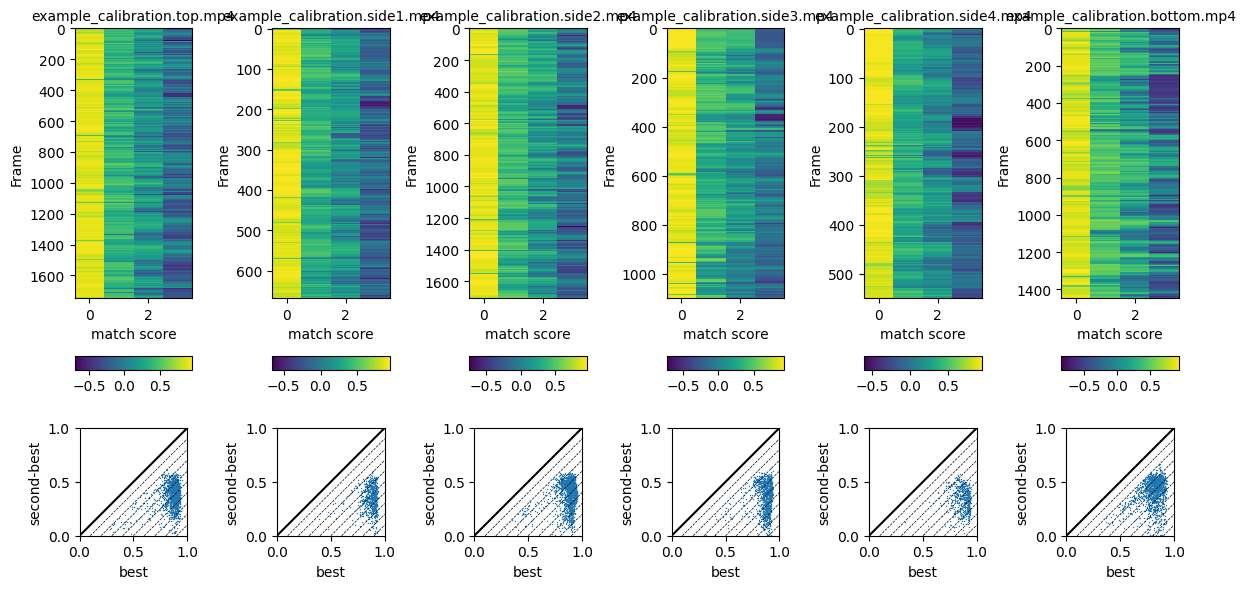

In [2]:
board_shape = (5,7)
square_size = 12.5

camera_names = ['top', 'side1', 'side2', 'side3', 'side4', 'bottom']
prefix = '../../tests/example_data/example_calibration'
video_paths = [f'{prefix}.{camera}.mp4' for camera in camera_names]

# detect calibration object in each video
all_calib_uvs, all_img_sizes = mcc.run_calibration_detection(
    video_paths, mcc.detect_chessboard, n_workers=6,
    detection_options=dict(board_shape=board_shape, scale_factor=0.5))

# display a table with the detections shared between camera pairs
mcc.summarize_detections(all_calib_uvs)

# plot corner-match scores for each frame
fig = mcc.plot_chessboard_qc_data(video_paths)

# optionally generate overlay videos
# for p in video_paths:
#     mcc.overlay_detections(p)


# Calibrate

## Initialization

In [3]:
calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)

all_extrinsics, all_intrinsics, calib_poses, spanning_tree = mcc.calibrate(
    all_calib_uvs, all_img_sizes, calib_objpoints, root=0, n_samples_for_intrinsics=100)


Estimating camera intrinsics


100%|█████████████████████████████████████| 6/6 [00:55<00:00,  9.21s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 6/6 [00:02<00:00,  2.22it/s]

Estimating camera extrinsics
Merging calibration object poses


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.63it/s]


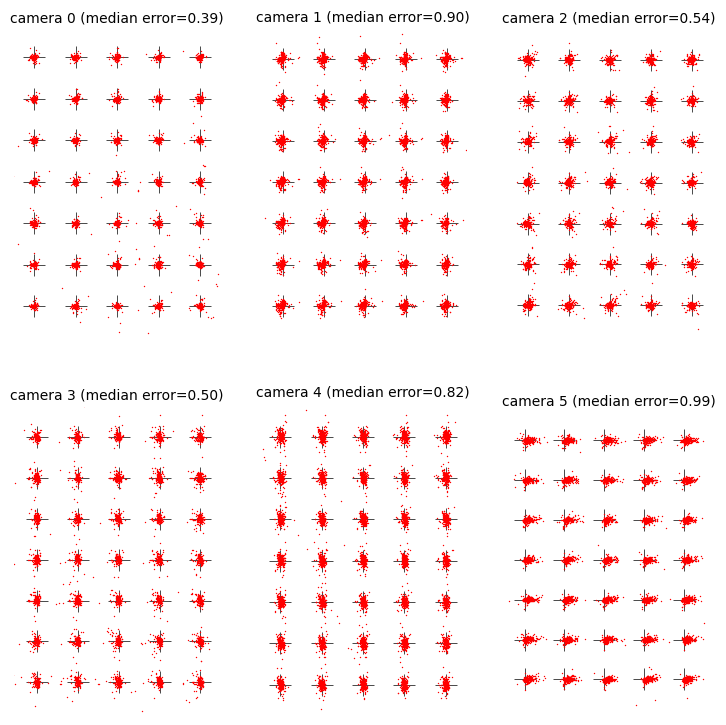

In [4]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, inches_per_axis=3)

## Bundle adjustment

In [5]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    mcc.bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=5000, ftol=1e-4)

/Users/calebweinreb/Dropbox (HMS)/caleb weinreb/PROJECTS/MOUSE_SURVEILANCE/22_3_1_keypoint_MOSEQ/23_8_11_sniff/multicam-calibration/multicam_calibration/bundle_adjustment.py:282: RuntimeWarning: All-NaN slice encountered
  outlier_threshold = 5 * np.nanmedian(err, axis=-1)


(2329,) (6, 2329, 35)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.76it/s]


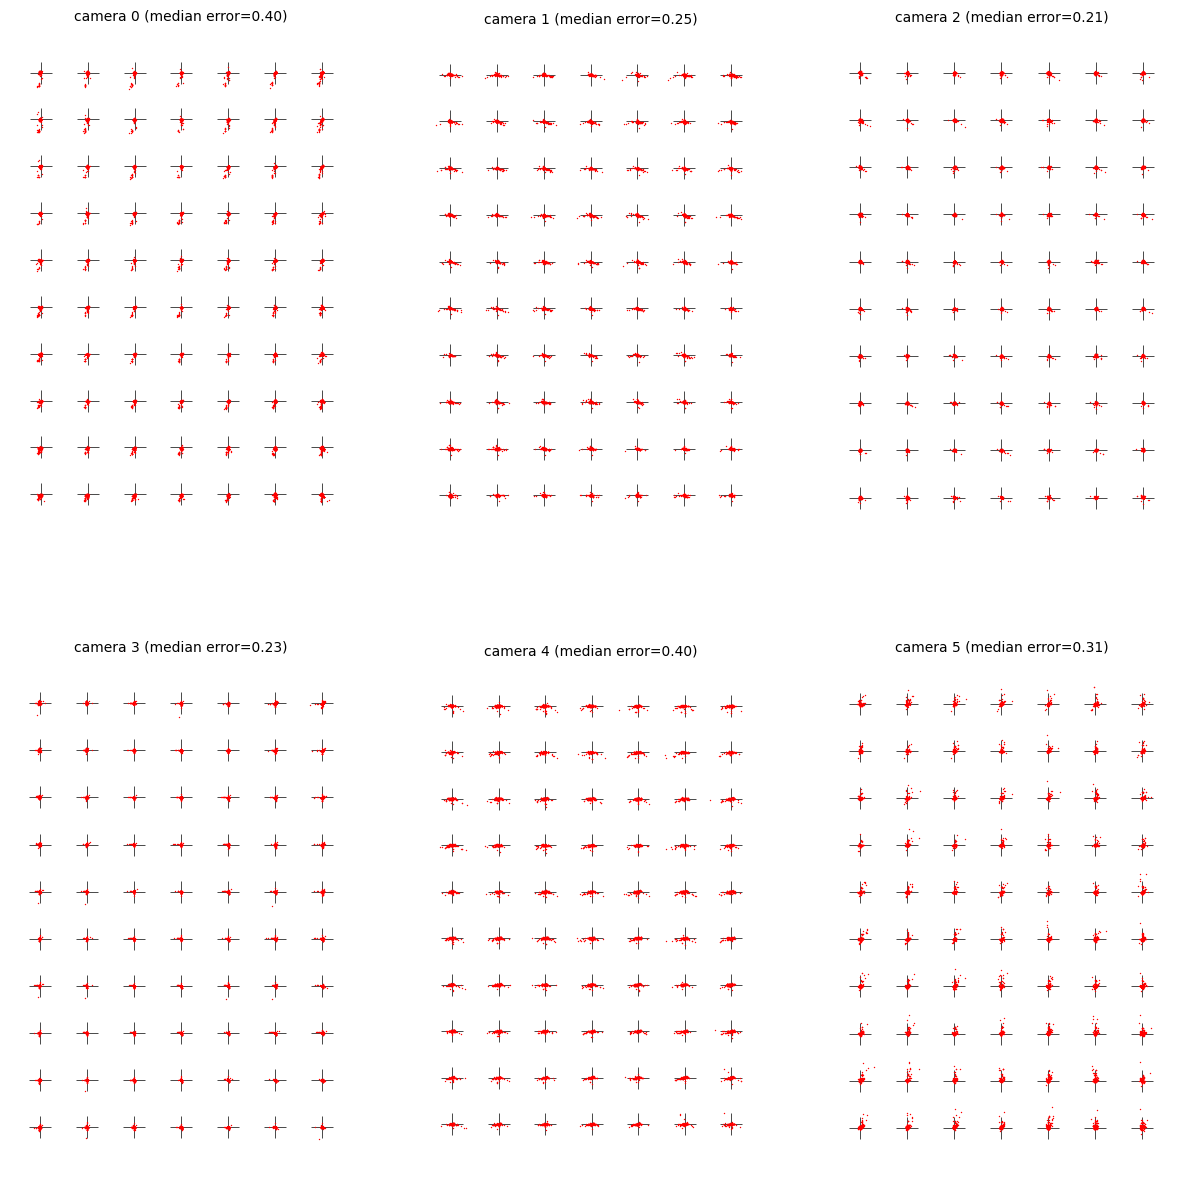

In [11]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses)

# Save results

In [13]:
# save for JARVIS
save_path = f'{video_dir}/CalibrationParameters/'
mcc.save_calibration(all_extrinsics, all_intrinsics, camera_names, save_path, save_format='jarvis')

# save for GIMBAL
save_path = f'{video_dir}/camera_params.h5'
mcc.save_calibration(all_extrinsics, all_intrinsics, camera_names, save_path, save_format='gimbal')